In [17]:
from game_of_life import Game_of_life
from autoencoder import ConvolutionalAutoencoder
from fullycon import CullyConnCoder

import torch.nn as nn
import torch
import tqdm
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

SIZE=16
SIM_BATHC = 6
ADVANCED_ENEI_PARAM = 0.0002 # THE LAN REGULARIZATION PARAMETER
ENEIAN_BIASING = 0.3

def generate_batch(batch_size, size, sims=SIM_BATHC, n_plus = 1, bias=0.5):
    with torch.no_grad():
        game = Game_of_life(size)
        game.to(device)
        # random binary noise of size size x size
        prev_batch = torch.rand((batch_size, 1, size, size), device=device)
        prev_batch = (prev_batch > bias).int()
        batch = game(prev_batch)

        for i in range(sims):
            batch, prev_batch = game(batch), batch

        for i in range(1, n_plus):
            batch = game(batch)

        return prev_batch, batch


def cell_count_MSE(outputs, labels, input):
    # count of dead cells in the output
    output_alive_cells = torch.sum(input == 1, dim=(1,2,3)).float()
    alive_cells = torch.sum(outputs == 1, dim=(1,2,3)).float()
    dead_cells = torch.sum(outputs == 0, dim=(1,2,3)).float()

    log_dead_cell  = torch.mean(torch.log(alive_cells / dead_cells + 1)) / (SIZE*SIZE)
    # step_diff = torch.mean(input - outputs) # ADVANCED_ENEI_PARAM
    # lanoid_fraction = torch.mean(torch.abs(alive_cells - output_alive_cells)) / (SIZE*SIZE)

    mse_loss = nn.MSELoss()(outputs, labels)

    loss = torch.add(mse_loss, ADVANCED_ENEI_PARAM * log_dead_cell )
    return loss

def train_model(epochs, lr):
    # Use the ResNet18 when implemented
    # net = ConvolutionalAutoencoder(SIZE)
    net = CullyConnCoder(SIZE)
    net.to(device)

    game = Game_of_life(SIZE)
    game.to(device)

    # Define the loss function
    # criterion = nn.BCELoss(reduction='mean') 
    # criterion = nn.MSELoss()
    criterion = cell_count_MSE

    # criterion = nn.CrossEntropyLoss()
    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    losses = []
    # loss_ra = 0
    for epoch in tqdm.tqdm(range(epochs)):
        # Get the inputs; Data is a tuple of (images, labels)
        inputs, labels = generate_batch(200, SIZE, SIM_BATHC, 1, ENEIAN_BIASING)

        
        for i in range(5):
            # Clear the saved gradients of the previous iteration
            optimizer.zero_grad()
            outputs = net(inputs)
            # print(torch.min(outputs[0]), torch.max(outputs[0]))
            
            # # Calculate the loss value
            loss = criterion(outputs.float(), labels.float(), inputs.float())
            losses.append(loss.data.cpu().detach().numpy())

            # # Calculate the gradients using backpropagation
            loss.backward()
            # loss_ra += loss.data.cpu().detach().numpy()
            # # Update the weights of the network using the chosen optimizer

            inputs = outputs
            labels = game(outputs < 0.5).float()
        
            optimizer.step()


        if (epoch % 100) == 0:
            # print(torch.sum(outputs[0] - labels[0]))
            print(loss.data.cpu().detach().numpy())
            # lr /= 1.1


    # net.eval()
    # test_bird_model(net,testloader)
    
    return net, losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import matplotlib.pyplot as plt
# torch.cuda.empty_cache()

net,losses = train_model(9000, 0.0005)
# prosim delaj



  0%|          | 0/9000 [00:00<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

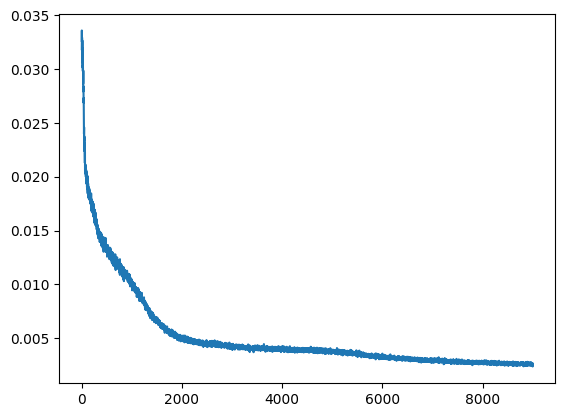

In [3]:
plt.plot(losses)
plt.show()

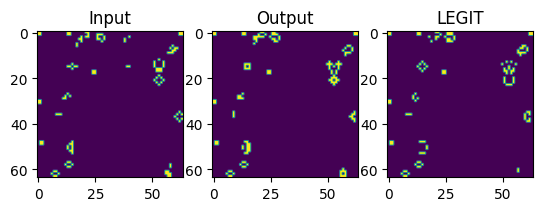

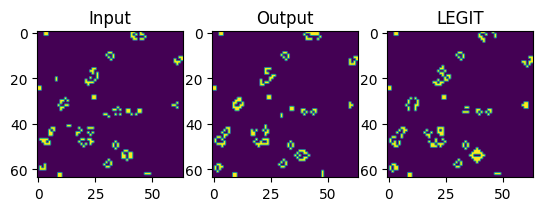

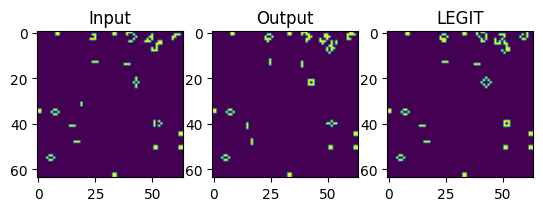

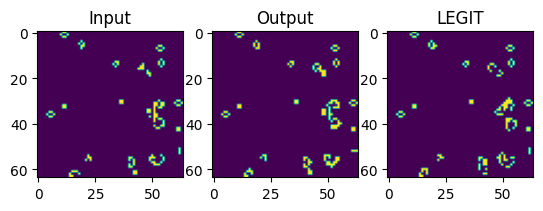

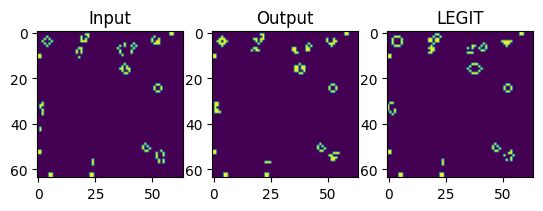

In [4]:
#RANDOM TRIES
batch, next= generate_batch(5, SIZE, SIM_BATHC, 2, ENEIAN_BIASING)
out = net(batch).cpu().detach().numpy()
out = out > 0.5
ba = batch.cpu().detach().numpy()
ne = next.cpu().detach().numpy()

for i in range(5):
    ins = ba[i][0]
    res = out[i][0]
    nes = ne[i][0]
    fix, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(ins)
    ax1.set_title("Input")
    ax2.imshow(res)
    ax2.set_title("Output")
    ax3.imshow(nes)
    ax3.set_title("LEGIT")


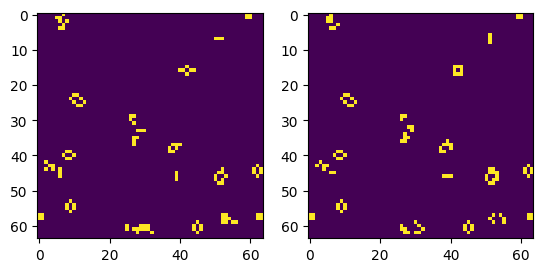

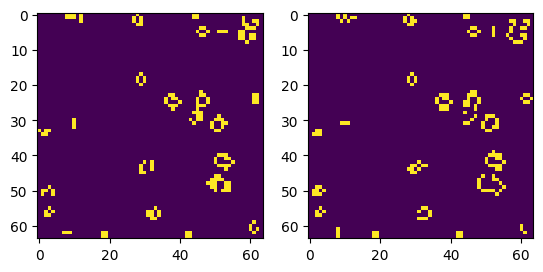

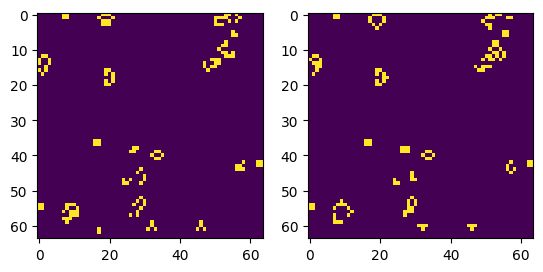

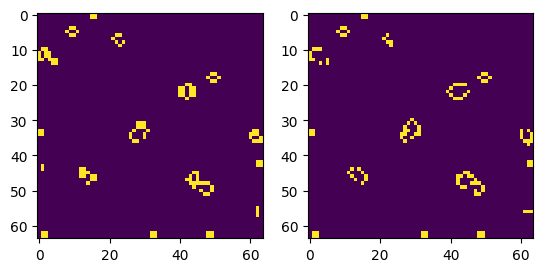

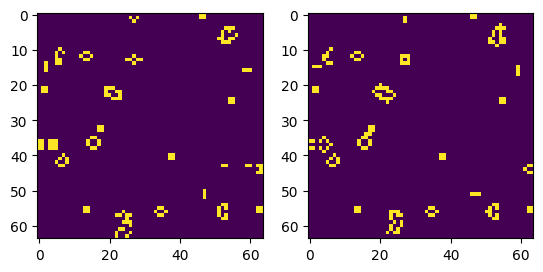

In [5]:
L = 5
out = generate_batch(L, SIZE, SIM_BATHC, 1, 0.3)
for i in range(L):
    ins = out[0][i][0].cpu().detach().numpy()
    res = out[1][i][0].cpu().detach().numpy()
    fix, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ins)
    ax2.imshow(res)

In [6]:
import pygame
SIZE = 256
GAME_SIZE = 4
WAIT = 20

calc_wait =round( WAIT / SIZE**0.5 ) 

def get_new(previous:torch.Tensor, net:torch.nn.Module):
    with torch.no_grad():
        tensor = net(previous)
        return tensor, tensor.squeeze().cpu().detach().numpy() > 0.5

def display_grid(grid, screen):
    size = len(grid)
    cell_size = GAME_SIZE
    for i in range(size):
        for j in range(size):
            if grid[i][j] == 1:
                pygame.draw.rect(screen, (255, 255, 255), (i*cell_size, j*cell_size, cell_size, cell_size))
            else:
                pygame.draw.rect(screen, (0, 0, 0), (i*cell_size, j*cell_size, cell_size, cell_size))
    pygame.display.flip()

first, second = generate_batch(1, SIZE, 15, 1, ENEIAN_BIASING)
tensor, grid = get_new(first, net)
pygame.init()
screen = pygame.display.set_mode((SIZE*GAME_SIZE, SIZE*GAME_SIZE))

running = True
i = 0
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_SPACE:
                running = False
        # r resetes game with new random grid
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_r:
                first, second = generate_batch(1, SIZE, 15, 1,ENEIAN_BIASING)
                tensor, grid = get_new(first, net)
        # plt.imshow(grid) and save it when S is pressed
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_s:
                plt.imshow(grid, cmap='gray')
                plt.savefig(f"grid_{i}.png")
    tensor, grid = get_new(tensor, net)
    display_grid(grid, screen)
    pygame.time.wait(calc_wait)
    # if(tensor.sum() == 0 or tensor.sum() == SIZE*SIZE):
    #     running = False
    i += 1

pygame.quit()

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [7]:
pygame.quit()